# Imports

In [351]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [352]:
N_EPOCHS = 600
BATCH_SIZE = 16
DATASET_SIZE = 249
TRAIN_DATA_SIZE = 96
LATENT_DIM = 128

# Data importing and pre-processing

In [353]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2)


normalize dataset data into range of sigmoid [0,1], and put into batches

In [354]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise example from dataset

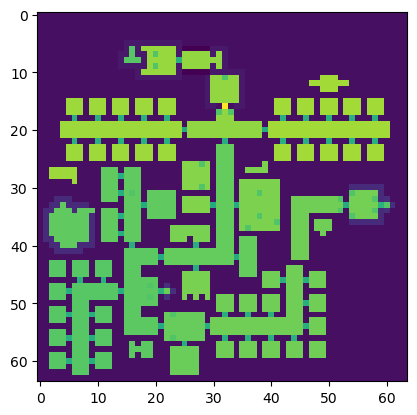

In [355]:
plt.imshow(df[0])

# Generator Model

Create points in latent space to be fed into generator

In [356]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [357]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))


    
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    


    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [358]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [359]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 8192)              1056768   
                                                                 
 batch_normalization_109 (B  (None, 8192)              32768     
 atchNormalization)                                              
                                                                 
 leaky_re_lu_129 (LeakyReLU  (None, 8192)              0         
 )                                                               
                                                                 
 reshape_20 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_80 (Conv2  (None, 16, 16, 64)        131072    
 DTranspose)                                                     
                                                     

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [360]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [361]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [362]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [363]:
gen_optimizer = Adam(learning_rate =0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate =0.0002, beta_1=0.5)

Discriminator accuracy

In [364]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [365]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [366]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    input_for_map_after_training = generate_generator_input(1)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

epoch = 0
generated map shape(16, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(16, 64, 64, 1)
generated map shape(16, 64, 64, 1)
Gen loss = tf.Tensor(0.09148666, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17312951, shape=(), dtype=float32)
Disc accuracy = 0.0


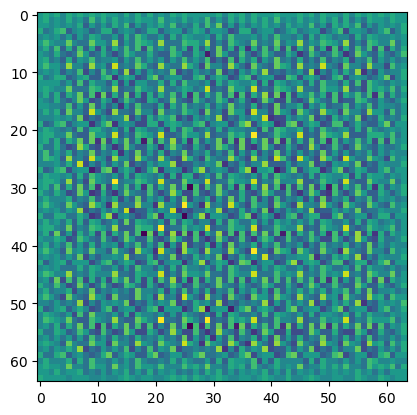

epoch = 1
Gen loss = tf.Tensor(0.09117389, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16227312, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 2
Gen loss = tf.Tensor(0.115630746, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16010052, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 3
Gen loss = tf.Tensor(0.13232139, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13847326, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 4
Gen loss = tf.Tensor(0.17216875, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08781587, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 5
Gen loss = tf.Tensor(0.15666346, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09244562, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 6
Gen loss = tf.Tensor(0.17589886, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08850315, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 7
Gen loss = tf.Tensor(0.12001545, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.170111, shape=(), dtype=f

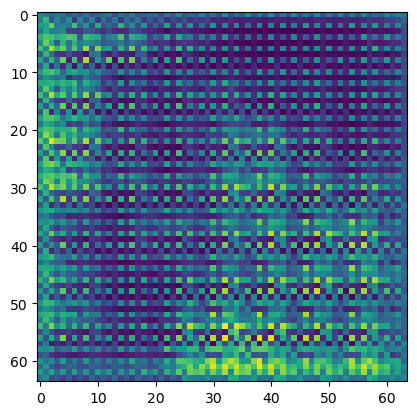

epoch = 11
Gen loss = tf.Tensor(0.08267907, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21993189, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 12
Gen loss = tf.Tensor(0.112599045, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19718955, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 13
Gen loss = tf.Tensor(0.11073477, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18368013, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 14
Gen loss = tf.Tensor(0.10971587, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17530008, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 15
Gen loss = tf.Tensor(0.10387405, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18883264, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 16
Gen loss = tf.Tensor(0.10303343, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18534642, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 17
Gen loss = tf.Tensor(0.101233065, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2040212, shape=()

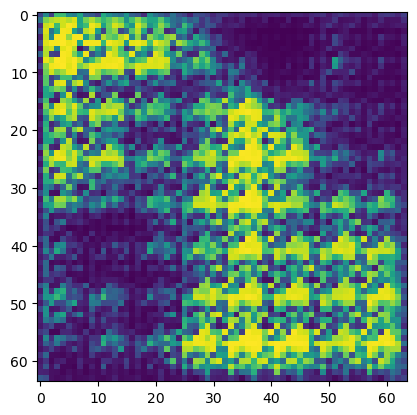

epoch = 21
Gen loss = tf.Tensor(0.107985616, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20139138, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 22
Gen loss = tf.Tensor(0.11346596, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18079315, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 23
Gen loss = tf.Tensor(0.12263685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15565924, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 24
Gen loss = tf.Tensor(0.099357806, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20742829, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 25
Gen loss = tf.Tensor(0.116508484, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17766054, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 26
Gen loss = tf.Tensor(0.09427629, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19575627, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 27
Gen loss = tf.Tensor(0.11018651, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18704498, shape=

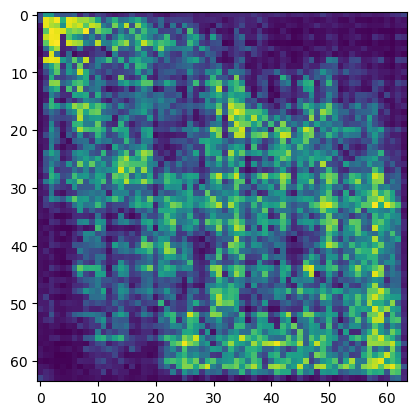

epoch = 31
Gen loss = tf.Tensor(0.08241764, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23445882, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 32
Gen loss = tf.Tensor(0.07640054, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24000148, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 33
Gen loss = tf.Tensor(0.076962866, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23824398, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 34
Gen loss = tf.Tensor(0.07948294, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23677748, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 35
Gen loss = tf.Tensor(0.07730727, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23566608, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 36
Gen loss = tf.Tensor(0.080026366, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22964998, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 37
Gen loss = tf.Tensor(0.07980458, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22204734, shape=(

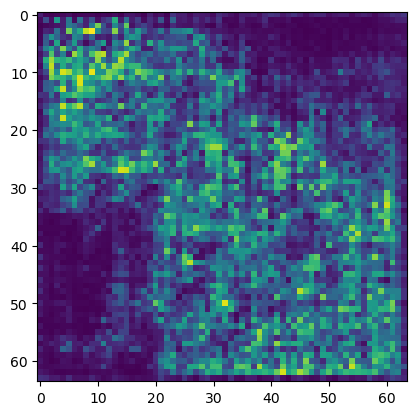

epoch = 41
Gen loss = tf.Tensor(0.083868586, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20921136, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 42
Gen loss = tf.Tensor(0.081412025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20801617, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 43
Gen loss = tf.Tensor(0.08366109, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2090866, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 44
Gen loss = tf.Tensor(0.08192632, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20918363, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 45
Gen loss = tf.Tensor(0.083478995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20611225, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 46
Gen loss = tf.Tensor(0.08109669, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20642865, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 47
Gen loss = tf.Tensor(0.07958769, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20756347, shape=(

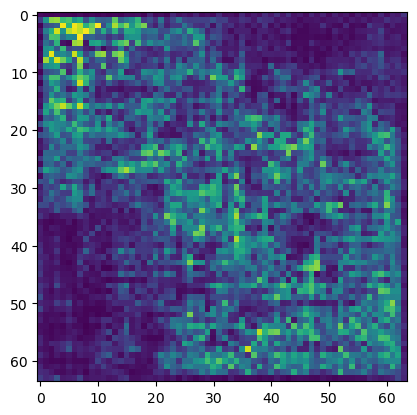

epoch = 51
Gen loss = tf.Tensor(0.08150438, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20382309, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 52
Gen loss = tf.Tensor(0.083591014, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20107533, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 53
Gen loss = tf.Tensor(0.0845716, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20090997, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 54
Gen loss = tf.Tensor(0.08274668, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20037706, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 55
Gen loss = tf.Tensor(0.08473187, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19838645, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 56
Gen loss = tf.Tensor(0.08615184, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.198734, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 57
Gen loss = tf.Tensor(0.090124935, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19697219, shape=(), 

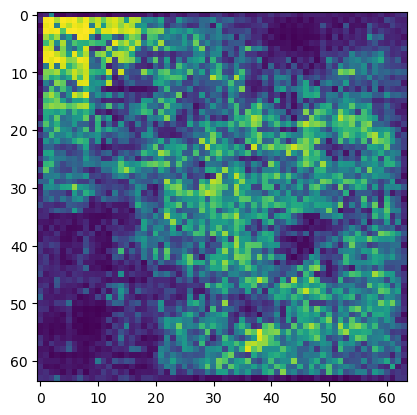

epoch = 61
Gen loss = tf.Tensor(0.08966559, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19664608, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 62
Gen loss = tf.Tensor(0.08965733, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19579394, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 63
Gen loss = tf.Tensor(0.09255606, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1945815, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 64
Gen loss = tf.Tensor(0.08903057, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1961175, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 65
Gen loss = tf.Tensor(0.091005005, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1958551, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 66
Gen loss = tf.Tensor(0.093524165, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19314848, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 67
Gen loss = tf.Tensor(0.09410825, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19212009, shape=(), 

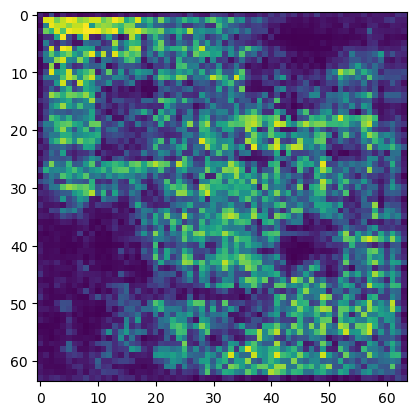

epoch = 71
Gen loss = tf.Tensor(0.09334146, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1897583, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 72
Gen loss = tf.Tensor(0.0944845, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19086032, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 73
Gen loss = tf.Tensor(0.09622475, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19187947, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 74
Gen loss = tf.Tensor(0.09308123, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18985285, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 75
Gen loss = tf.Tensor(0.093047984, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19243157, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 76
Gen loss = tf.Tensor(0.0957431, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18816827, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 77
Gen loss = tf.Tensor(0.0939165, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19136418, shape=(), dt

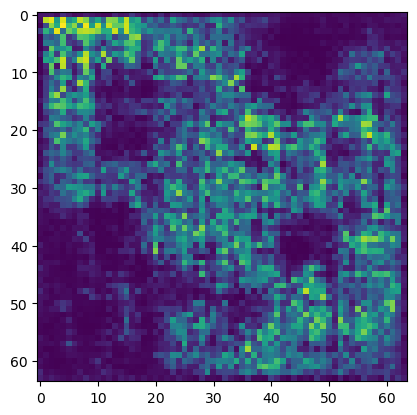

epoch = 81
Gen loss = tf.Tensor(0.09249153, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1937273, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 82
Gen loss = tf.Tensor(0.098417096, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1864208, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 83
Gen loss = tf.Tensor(0.09410017, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19029097, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 84
Gen loss = tf.Tensor(0.09230635, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18456991, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 85
Gen loss = tf.Tensor(0.09633965, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19082475, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 86
Gen loss = tf.Tensor(0.0966017, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18621226, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 87
Gen loss = tf.Tensor(0.094334535, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18969649, shape=(), 

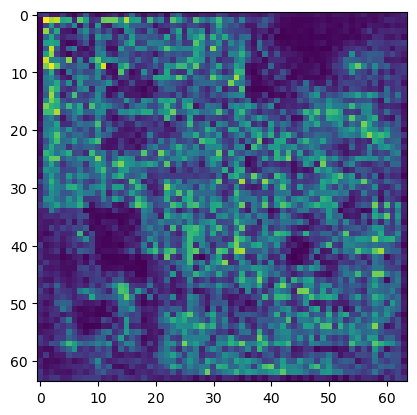

epoch = 91
Gen loss = tf.Tensor(0.094412185, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18840988, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 92
Gen loss = tf.Tensor(0.10092374, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18207449, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 93
Gen loss = tf.Tensor(0.09053096, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18610235, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 94
Gen loss = tf.Tensor(0.09558857, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18551596, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 95
Gen loss = tf.Tensor(0.10445595, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1850128, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 96
Gen loss = tf.Tensor(0.095762394, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18342167, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 97
Gen loss = tf.Tensor(0.097205214, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18532221, shape=(

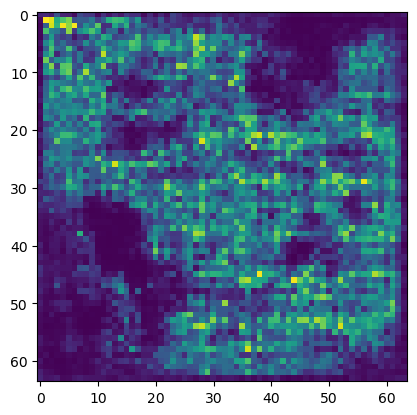

epoch = 101
Gen loss = tf.Tensor(0.10015529, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18512289, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 102
Gen loss = tf.Tensor(0.0911834, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18255733, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 103
Gen loss = tf.Tensor(0.097717606, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18368377, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 104
Gen loss = tf.Tensor(0.098166764, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1829385, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 105
Gen loss = tf.Tensor(0.09380082, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18143542, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 106
Gen loss = tf.Tensor(0.09903025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18210518, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 107
Gen loss = tf.Tensor(0.09465899, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18063253, sh

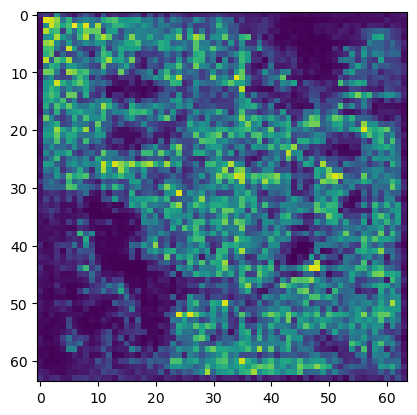

epoch = 111
Gen loss = tf.Tensor(0.09953749, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18300991, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 112
Gen loss = tf.Tensor(0.10145249, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17977935, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 113
Gen loss = tf.Tensor(0.100184225, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18094103, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 114
Gen loss = tf.Tensor(0.097195484, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17679529, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 115
Gen loss = tf.Tensor(0.099822186, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1831591, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 116
Gen loss = tf.Tensor(0.09247913, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17940736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 117
Gen loss = tf.Tensor(0.100895636, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17426161,

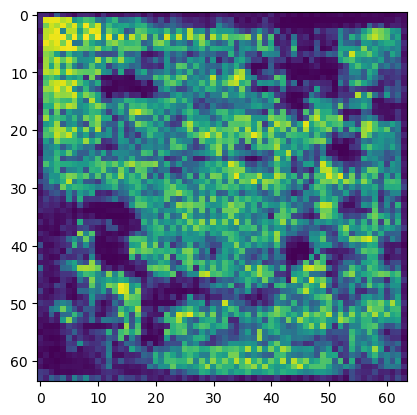

epoch = 121
Gen loss = tf.Tensor(0.10950401, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17776315, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 122
Gen loss = tf.Tensor(0.10303479, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17473827, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 123
Gen loss = tf.Tensor(0.10835936, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17493398, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 124
Gen loss = tf.Tensor(0.10157388, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17695029, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 125
Gen loss = tf.Tensor(0.100613296, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17481767, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 126
Gen loss = tf.Tensor(0.098742776, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17606771, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 127
Gen loss = tf.Tensor(0.09282709, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17744619, 

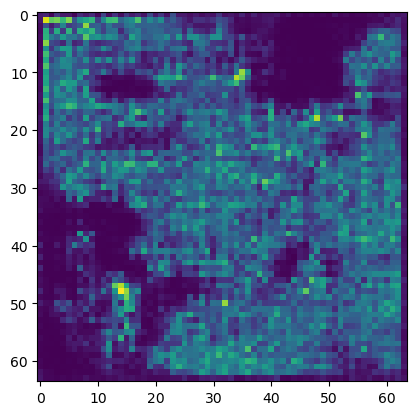

epoch = 131
Gen loss = tf.Tensor(0.09586548, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1767342, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 132
Gen loss = tf.Tensor(0.10144859, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17873442, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 133
Gen loss = tf.Tensor(0.098448895, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1710424, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 134
Gen loss = tf.Tensor(0.10190629, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17236672, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 135
Gen loss = tf.Tensor(0.105160214, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17353594, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 136
Gen loss = tf.Tensor(0.09954584, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17154793, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 137
Gen loss = tf.Tensor(0.113527745, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17232513, s

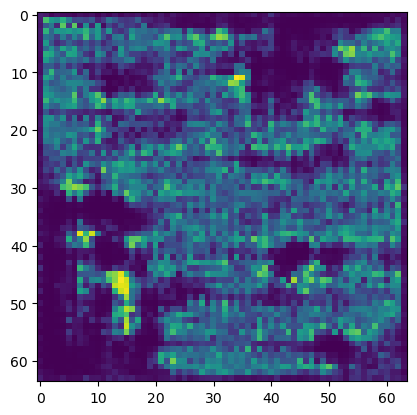

epoch = 141
Gen loss = tf.Tensor(0.10587152, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16798355, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 142
Gen loss = tf.Tensor(0.1024581, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17235138, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 143
Gen loss = tf.Tensor(0.108264305, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16865957, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 144
Gen loss = tf.Tensor(0.100337446, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17411341, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 145
Gen loss = tf.Tensor(0.10846821, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16650923, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 146
Gen loss = tf.Tensor(0.10099089, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17024016, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 147
Gen loss = tf.Tensor(0.11982327, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15978317, s

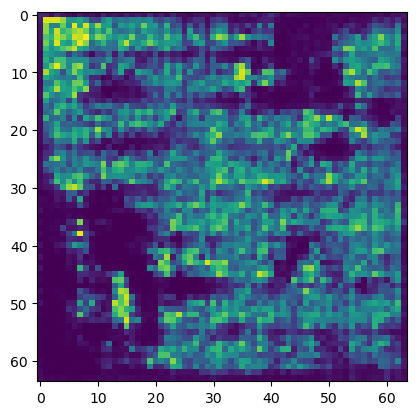

epoch = 151
Gen loss = tf.Tensor(0.110548176, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16474533, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 152
Gen loss = tf.Tensor(0.10750691, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16373736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 153
Gen loss = tf.Tensor(0.11491424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16099064, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 154
Gen loss = tf.Tensor(0.11247843, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16563843, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 155
Gen loss = tf.Tensor(0.107878625, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16025873, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 156
Gen loss = tf.Tensor(0.11199816, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16440298, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 157
Gen loss = tf.Tensor(0.1118822, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1592889, sh

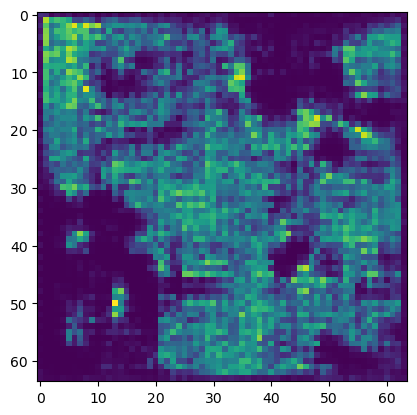

epoch = 161
Gen loss = tf.Tensor(0.11226866, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15981007, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 162
Gen loss = tf.Tensor(0.11320162, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15990312, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 163
Gen loss = tf.Tensor(0.12154153, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14700527, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 164
Gen loss = tf.Tensor(0.12031699, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14657407, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 165
Gen loss = tf.Tensor(0.1254224, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15291782, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 166
Gen loss = tf.Tensor(0.12552449, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14773147, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 167
Gen loss = tf.Tensor(0.1454427, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14571287, shap

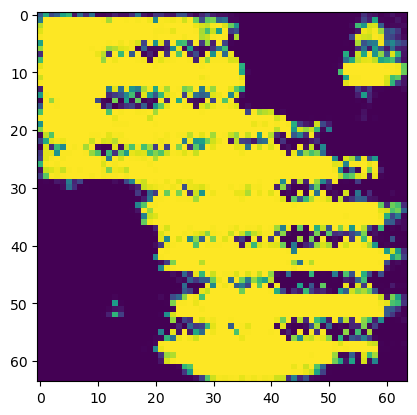

epoch = 171
Gen loss = tf.Tensor(0.1610033, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11845269, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 172
Gen loss = tf.Tensor(0.1967747, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07035954, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 173
Gen loss = tf.Tensor(0.20707707, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.067983255, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 174
Gen loss = tf.Tensor(0.17040342, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13411523, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 175
Gen loss = tf.Tensor(0.2504569, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08819679, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 176
Gen loss = tf.Tensor(0.32585654, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036013246, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 177
Gen loss = tf.Tensor(0.19910233, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09524038, sha

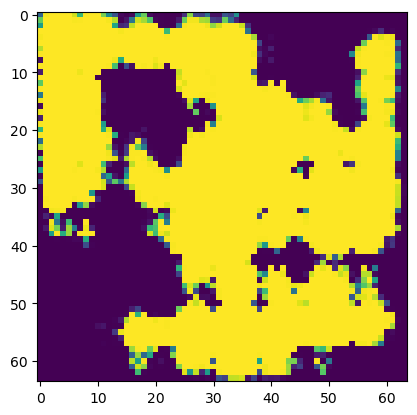

epoch = 181
Gen loss = tf.Tensor(0.17677052, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.112169355, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 182
Gen loss = tf.Tensor(0.29144135, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04933821, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 183
Gen loss = tf.Tensor(0.20590454, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0913542, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 184
Gen loss = tf.Tensor(0.25875998, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08688623, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 185
Gen loss = tf.Tensor(0.21844731, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09756722, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 186
Gen loss = tf.Tensor(0.2461182, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06410166, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 187
Gen loss = tf.Tensor(0.1882966, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10523159, shap

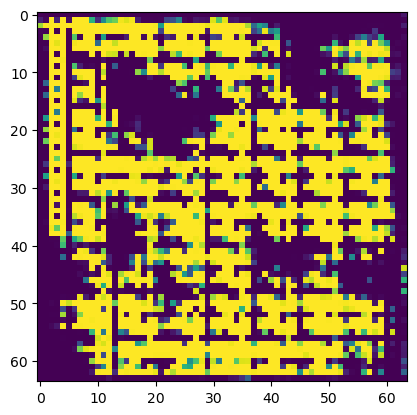

epoch = 191
Gen loss = tf.Tensor(0.2585409, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05851573, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 192
Gen loss = tf.Tensor(0.22929166, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.075506166, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 193
Gen loss = tf.Tensor(0.257296, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056155384, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 194
Gen loss = tf.Tensor(0.2652466, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05520232, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 195
Gen loss = tf.Tensor(0.2621738, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061379705, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 196
Gen loss = tf.Tensor(0.2859307, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050982777, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 197
Gen loss = tf.Tensor(0.24031778, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08139703, shap

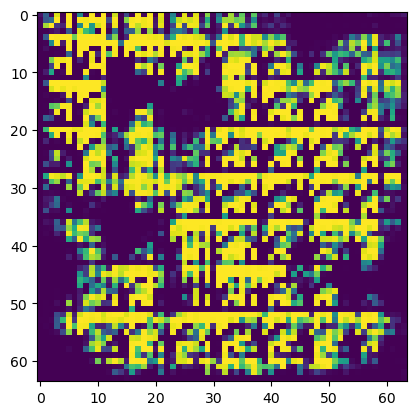

epoch = 201
Gen loss = tf.Tensor(0.2555342, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055094585, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 202
Gen loss = tf.Tensor(0.3104951, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038563605, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 203
Gen loss = tf.Tensor(0.21643485, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.078204475, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 204
Gen loss = tf.Tensor(0.23231979, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08642792, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 205
Gen loss = tf.Tensor(0.22653346, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10257832, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 206
Gen loss = tf.Tensor(0.32037315, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.066998586, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 207
Gen loss = tf.Tensor(0.11605439, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16325574, 

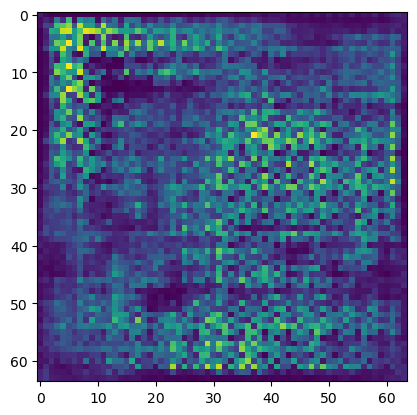

epoch = 211
Gen loss = tf.Tensor(0.12067443, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1633208, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 212
Gen loss = tf.Tensor(0.14096558, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14265126, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 213
Gen loss = tf.Tensor(0.16398492, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.119070746, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 214
Gen loss = tf.Tensor(0.1885364, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10719805, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 215
Gen loss = tf.Tensor(0.22118, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08428841, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 216
Gen loss = tf.Tensor(0.20019273, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08913223, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 217
Gen loss = tf.Tensor(0.2045876, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08673349, shape=(

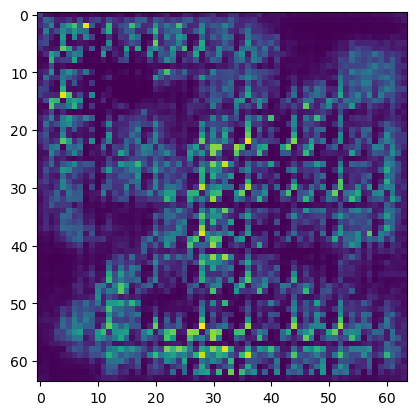

epoch = 221
Gen loss = tf.Tensor(0.16053116, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12119139, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 222
Gen loss = tf.Tensor(0.1672445, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1193695, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 223
Gen loss = tf.Tensor(0.16513275, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.110256426, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 224
Gen loss = tf.Tensor(0.1592202, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13021134, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 225
Gen loss = tf.Tensor(0.18185438, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1046266, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 226
Gen loss = tf.Tensor(0.19736104, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08613356, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 227
Gen loss = tf.Tensor(0.21107358, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08430824, shape

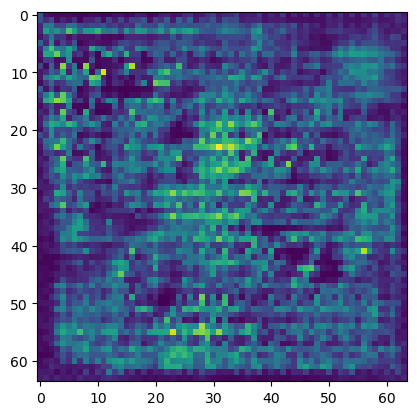

epoch = 231
Gen loss = tf.Tensor(0.18536414, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.104622446, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 232
Gen loss = tf.Tensor(0.1873532, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10826233, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 233
Gen loss = tf.Tensor(0.18677805, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11174866, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 234
Gen loss = tf.Tensor(0.18524076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10691743, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 235
Gen loss = tf.Tensor(0.19682677, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10628449, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 236
Gen loss = tf.Tensor(0.18403518, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.109970324, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 237
Gen loss = tf.Tensor(0.18198697, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.106014825, 

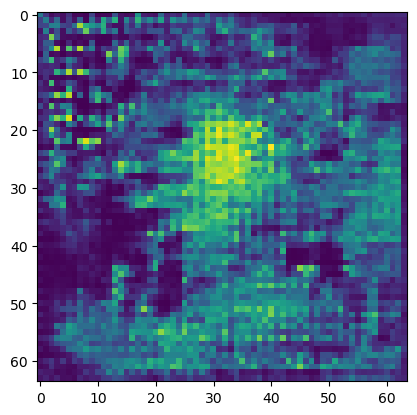

epoch = 241
Gen loss = tf.Tensor(0.18330713, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12360439, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 242
Gen loss = tf.Tensor(0.18695664, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.112680584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 243
Gen loss = tf.Tensor(0.19573648, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09726038, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 244
Gen loss = tf.Tensor(0.19889052, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10079669, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 245
Gen loss = tf.Tensor(0.2084009, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.088437766, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 246
Gen loss = tf.Tensor(0.214855, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09223476, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 247
Gen loss = tf.Tensor(0.22925587, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08166356, sha

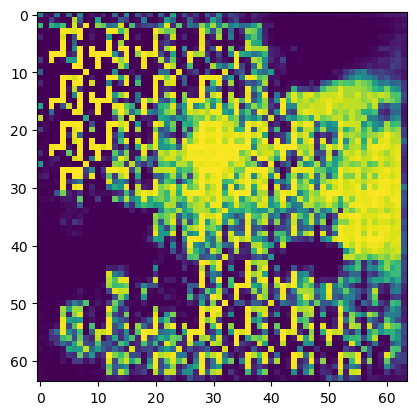

epoch = 251
Gen loss = tf.Tensor(0.23718649, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07625361, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 252
Gen loss = tf.Tensor(0.2549574, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06681066, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 253
Gen loss = tf.Tensor(0.2863927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048644304, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 254
Gen loss = tf.Tensor(0.2815913, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06480596, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 255
Gen loss = tf.Tensor(0.307142, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058287933, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 256
Gen loss = tf.Tensor(0.40375793, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03647343, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 257
Gen loss = tf.Tensor(0.34514013, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043547735, shap

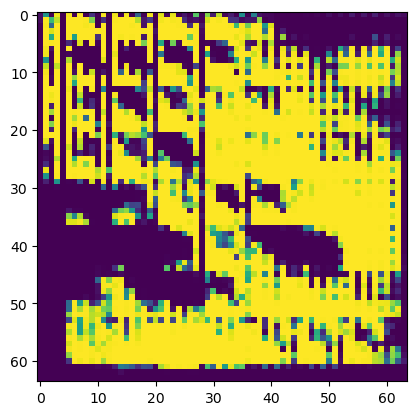

epoch = 261
Gen loss = tf.Tensor(0.287691, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.053788006, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 262
Gen loss = tf.Tensor(0.29915658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054432396, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 263
Gen loss = tf.Tensor(0.36057678, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.033669062, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 264
Gen loss = tf.Tensor(0.3430475, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036728475, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 265
Gen loss = tf.Tensor(0.38533008, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029137759, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 266
Gen loss = tf.Tensor(0.344247, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04605378, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 267
Gen loss = tf.Tensor(0.3922173, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03423814, sha

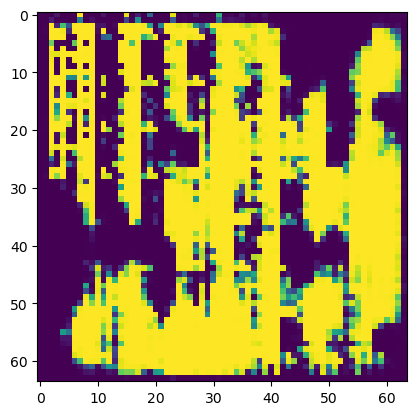

epoch = 271
Gen loss = tf.Tensor(0.33659813, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037492402, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 272
Gen loss = tf.Tensor(0.41945362, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022592297, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 273
Gen loss = tf.Tensor(0.36239517, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03361967, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 274
Gen loss = tf.Tensor(0.389537, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03111017, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 275
Gen loss = tf.Tensor(0.3489108, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.033062376, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 276
Gen loss = tf.Tensor(0.38808703, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026852958, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 277
Gen loss = tf.Tensor(0.36275423, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029058198, 

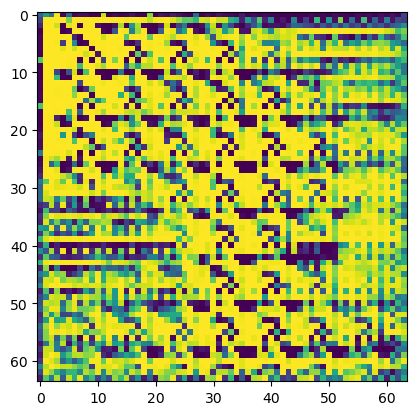

epoch = 281
Gen loss = tf.Tensor(0.5026397, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040614266, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 282
Gen loss = tf.Tensor(0.36936948, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045999814, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 283
Gen loss = tf.Tensor(0.3834126, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036352564, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 284
Gen loss = tf.Tensor(0.40550008, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03766411, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 285
Gen loss = tf.Tensor(0.3429192, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059135426, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 286
Gen loss = tf.Tensor(0.16631408, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1625498, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 287
Gen loss = tf.Tensor(0.2795942, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059625816, sh

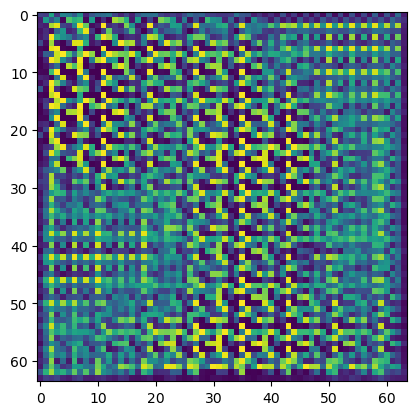

epoch = 291
Gen loss = tf.Tensor(0.3503569, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.031729396, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 292
Gen loss = tf.Tensor(0.32333115, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04678895, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 293
Gen loss = tf.Tensor(0.26468042, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060879577, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 294
Gen loss = tf.Tensor(0.22796972, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09548688, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 295
Gen loss = tf.Tensor(0.2406642, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07980441, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 296
Gen loss = tf.Tensor(0.3203539, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06438165, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 297
Gen loss = tf.Tensor(0.36961412, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03099254, sha

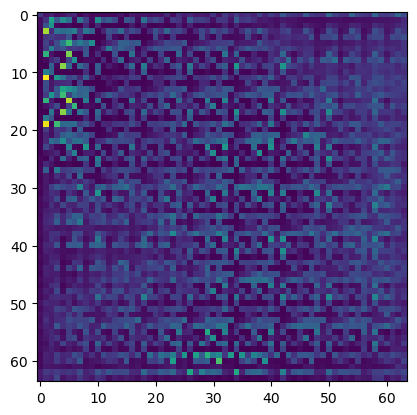

epoch = 301
Gen loss = tf.Tensor(0.29268014, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045120776, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 302
Gen loss = tf.Tensor(0.35438552, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029429412, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 303
Gen loss = tf.Tensor(0.3943043, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.021913694, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 304
Gen loss = tf.Tensor(0.36371055, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024780525, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 305
Gen loss = tf.Tensor(0.35917544, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026295453, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 306
Gen loss = tf.Tensor(0.3873022, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024263717, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 307
Gen loss = tf.Tensor(0.42824504, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01371923

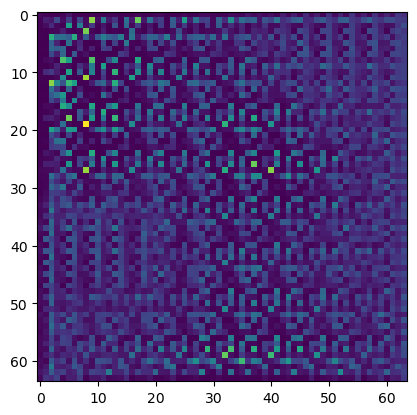

epoch = 311
Gen loss = tf.Tensor(0.4699988, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009131351, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 312
Gen loss = tf.Tensor(0.4319937, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011402438, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 313
Gen loss = tf.Tensor(0.43401095, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012237638, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 314
Gen loss = tf.Tensor(0.43725476, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012528555, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 315
Gen loss = tf.Tensor(0.42908338, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012718561, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 316
Gen loss = tf.Tensor(0.34500882, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09524548, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 317
Gen loss = tf.Tensor(0.31445828, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0983004, 

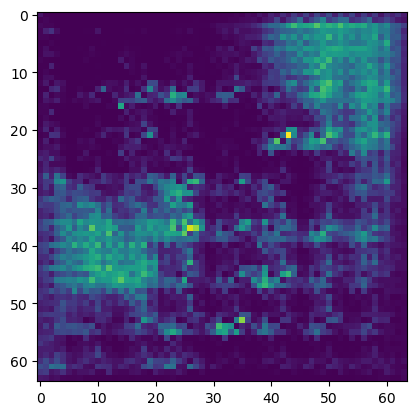

epoch = 321
Gen loss = tf.Tensor(0.31376657, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04720496, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 322
Gen loss = tf.Tensor(0.3734212, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03411363, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 323
Gen loss = tf.Tensor(0.39169538, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.031335555, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 324
Gen loss = tf.Tensor(0.3849511, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.033955038, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 325
Gen loss = tf.Tensor(0.3642472, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03789201, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 326
Gen loss = tf.Tensor(0.32673153, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04863337, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 327
Gen loss = tf.Tensor(0.321198, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060743675, shap

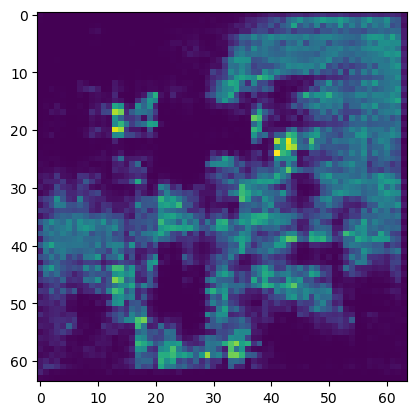

epoch = 331
Gen loss = tf.Tensor(0.3286899, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040400103, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 332
Gen loss = tf.Tensor(0.3299681, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048246875, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 333
Gen loss = tf.Tensor(0.311577, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048320238, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 334
Gen loss = tf.Tensor(0.31309465, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044280663, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 335
Gen loss = tf.Tensor(0.33154044, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042996366, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 336
Gen loss = tf.Tensor(0.33835378, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043609966, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 337
Gen loss = tf.Tensor(0.34242257, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042900514,

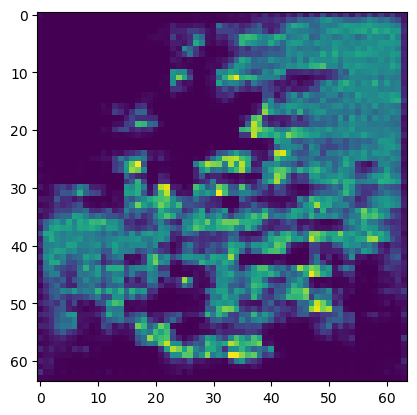

epoch = 341
Gen loss = tf.Tensor(0.34625527, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036910743, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 342
Gen loss = tf.Tensor(0.32202575, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04597193, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 343
Gen loss = tf.Tensor(0.31132737, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058110792, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 344
Gen loss = tf.Tensor(0.29118744, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06553892, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 345
Gen loss = tf.Tensor(0.303678, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05702815, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 346
Gen loss = tf.Tensor(0.3387171, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05840193, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 347
Gen loss = tf.Tensor(0.3169388, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051115427, sha

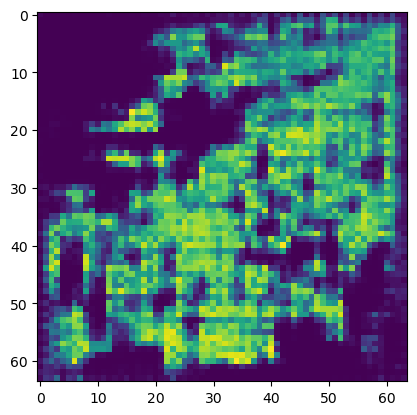

epoch = 351
Gen loss = tf.Tensor(0.36034676, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04755054, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 352
Gen loss = tf.Tensor(0.3400823, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05123681, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 353
Gen loss = tf.Tensor(0.3498435, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04638337, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 354
Gen loss = tf.Tensor(0.3400601, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050855055, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 355
Gen loss = tf.Tensor(0.34721288, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046113353, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 356
Gen loss = tf.Tensor(0.33688417, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.053032238, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 357
Gen loss = tf.Tensor(0.35504624, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045799475, s

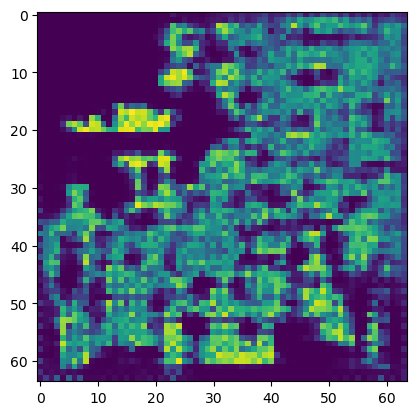

epoch = 361
Gen loss = tf.Tensor(0.3234947, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058277816, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 362
Gen loss = tf.Tensor(0.34863615, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06258514, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 363
Gen loss = tf.Tensor(0.32047328, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.055716082, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 364
Gen loss = tf.Tensor(0.32960063, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056414556, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 365
Gen loss = tf.Tensor(0.28100982, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07944253, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 366
Gen loss = tf.Tensor(0.3012424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061089825, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 367
Gen loss = tf.Tensor(0.29320312, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05523919, 

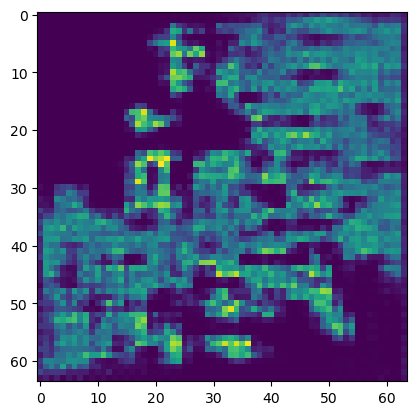

epoch = 371
Gen loss = tf.Tensor(0.32550237, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043100182, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 372
Gen loss = tf.Tensor(0.31989917, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05511206, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 373
Gen loss = tf.Tensor(0.33037743, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05009544, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 374
Gen loss = tf.Tensor(0.3292788, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0423328, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 375
Gen loss = tf.Tensor(0.34218034, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05012771, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 376
Gen loss = tf.Tensor(0.34391868, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041991603, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 377
Gen loss = tf.Tensor(0.36371255, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03410905, sh

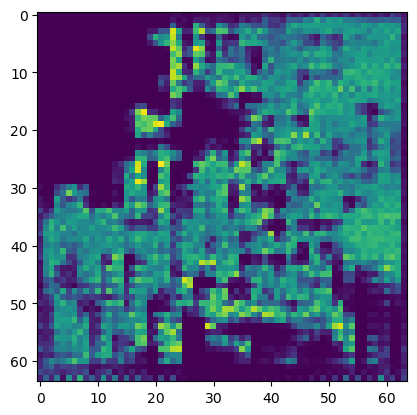

epoch = 381
Gen loss = tf.Tensor(0.36711368, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04245768, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 382
Gen loss = tf.Tensor(0.3561647, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040680613, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 383
Gen loss = tf.Tensor(0.3622253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044004887, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 384
Gen loss = tf.Tensor(0.36482623, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04506882, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 385
Gen loss = tf.Tensor(0.3862134, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03006673, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 386
Gen loss = tf.Tensor(0.34824803, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03647879, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 387
Gen loss = tf.Tensor(0.34563145, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05424471, sha

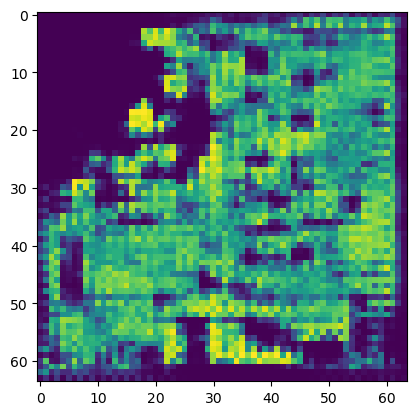

epoch = 391
Gen loss = tf.Tensor(0.3369207, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04595026, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 392
Gen loss = tf.Tensor(0.3445915, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045885477, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 393
Gen loss = tf.Tensor(0.34045646, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04304369, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 394
Gen loss = tf.Tensor(0.36462453, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03798652, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 395
Gen loss = tf.Tensor(0.39874366, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.031577792, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 396
Gen loss = tf.Tensor(0.3728714, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04254285, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 397
Gen loss = tf.Tensor(0.38093904, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036363255, sh

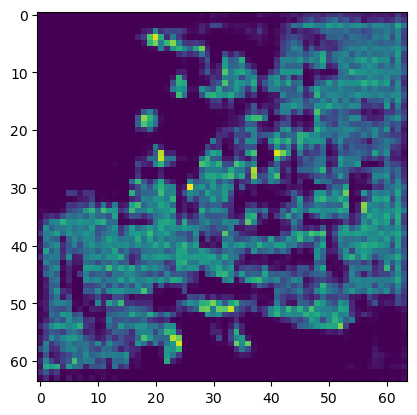

epoch = 401
Gen loss = tf.Tensor(0.3677241, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056016784, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 402
Gen loss = tf.Tensor(0.34463155, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05466393, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 403
Gen loss = tf.Tensor(0.33123103, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048854116, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 404
Gen loss = tf.Tensor(0.36923513, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051669378, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 405
Gen loss = tf.Tensor(0.36723292, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05167666, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 406
Gen loss = tf.Tensor(0.3735987, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039866354, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 407
Gen loss = tf.Tensor(0.35843822, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05297492, 

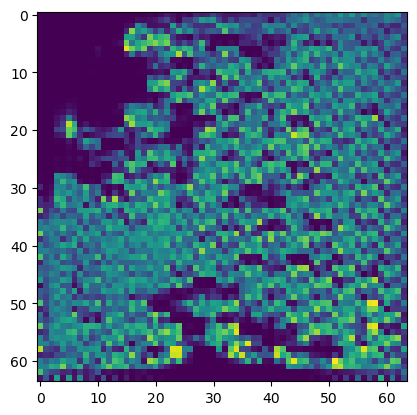

epoch = 411
Gen loss = tf.Tensor(0.3603007, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.062175322, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 412
Gen loss = tf.Tensor(0.36015323, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054748088, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 413
Gen loss = tf.Tensor(0.37206256, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050737385, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 414
Gen loss = tf.Tensor(0.43220937, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03629412, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 415
Gen loss = tf.Tensor(0.37769437, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056497816, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 416
Gen loss = tf.Tensor(0.49187005, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037441313, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 417
Gen loss = tf.Tensor(0.45607814, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02757101

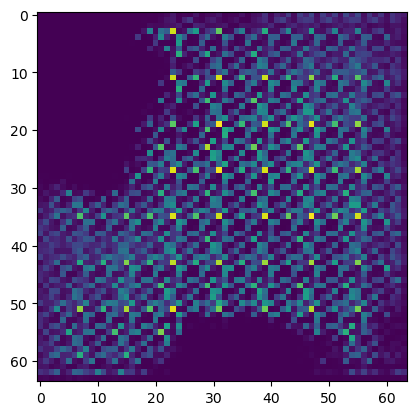

epoch = 421
Gen loss = tf.Tensor(0.4571215, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02062689, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 422
Gen loss = tf.Tensor(0.38235053, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03731634, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 423
Gen loss = tf.Tensor(0.4029797, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03858356, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 424
Gen loss = tf.Tensor(0.44007882, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022043422, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 425
Gen loss = tf.Tensor(0.43915752, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020608408, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 426
Gen loss = tf.Tensor(0.45256963, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02000904, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 427
Gen loss = tf.Tensor(0.47340074, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017694233, s

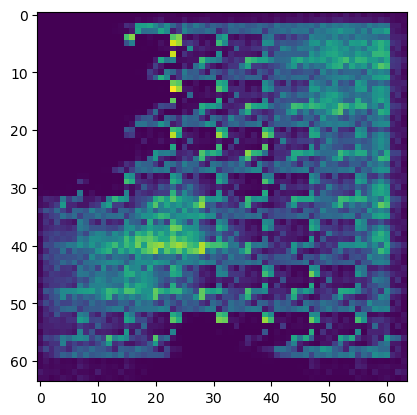

epoch = 431
Gen loss = tf.Tensor(0.42281005, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029192975, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 432
Gen loss = tf.Tensor(0.49697044, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016087094, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 433
Gen loss = tf.Tensor(0.39516675, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025435777, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 434
Gen loss = tf.Tensor(0.4519376, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017378375, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 435
Gen loss = tf.Tensor(0.38606372, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043983076, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 436
Gen loss = tf.Tensor(0.4187286, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024411703, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 437
Gen loss = tf.Tensor(0.53675413, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01221100

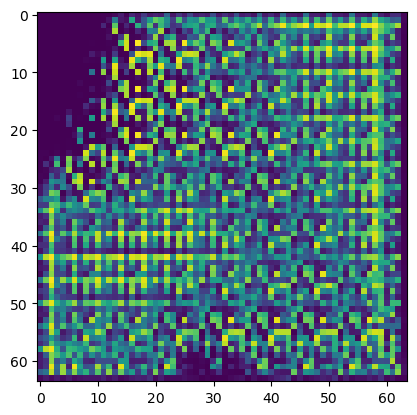

epoch = 441
Gen loss = tf.Tensor(0.43251228, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03993672, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 442
Gen loss = tf.Tensor(0.5501013, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0399521, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 443
Gen loss = tf.Tensor(0.5562631, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017510151, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 444
Gen loss = tf.Tensor(0.63369924, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013890726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 445
Gen loss = tf.Tensor(0.5687021, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037044365, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 446
Gen loss = tf.Tensor(0.6319344, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011845812, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 447
Gen loss = tf.Tensor(0.5071087, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040727835, sha

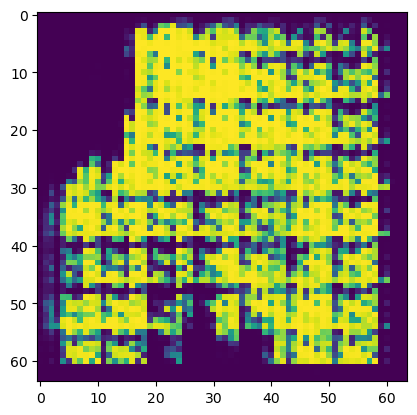

epoch = 451
Gen loss = tf.Tensor(0.5883103, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015079995, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 452
Gen loss = tf.Tensor(0.61149806, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012385458, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 453
Gen loss = tf.Tensor(0.5772302, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020187126, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 454
Gen loss = tf.Tensor(0.5341481, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015125711, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 455
Gen loss = tf.Tensor(0.5710767, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015149798, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 456
Gen loss = tf.Tensor(0.59626776, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007816867, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 457
Gen loss = tf.Tensor(0.6547428, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008578847, 

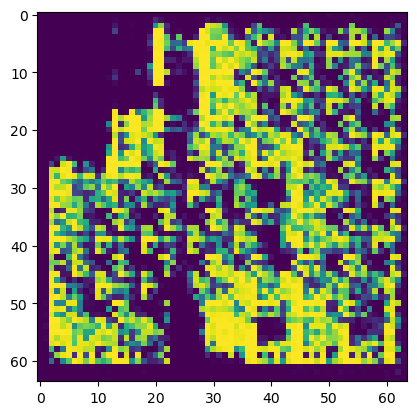

epoch = 461
Gen loss = tf.Tensor(0.5048669, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015395726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 462
Gen loss = tf.Tensor(0.52349067, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014036481, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 463
Gen loss = tf.Tensor(0.5344148, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013088178, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 464
Gen loss = tf.Tensor(0.4951947, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022593038, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 465
Gen loss = tf.Tensor(0.5186619, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020283625, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 466
Gen loss = tf.Tensor(0.53766656, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0167399, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 467
Gen loss = tf.Tensor(0.5030034, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025690435, sh

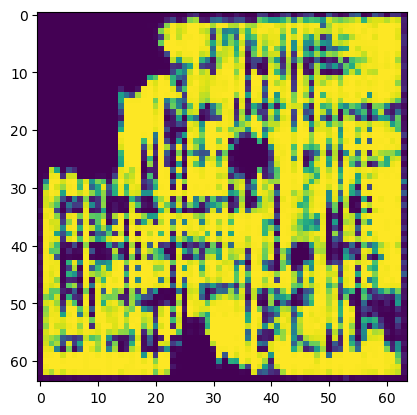

epoch = 471
Gen loss = tf.Tensor(0.50842977, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024060532, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 472
Gen loss = tf.Tensor(0.4587716, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.028238045, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 473
Gen loss = tf.Tensor(0.4889834, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024154996, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 474
Gen loss = tf.Tensor(0.533204, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017753435, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 475
Gen loss = tf.Tensor(0.49943987, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018691363, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 476
Gen loss = tf.Tensor(0.50728685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023944588, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 477
Gen loss = tf.Tensor(0.5117968, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016175726, 

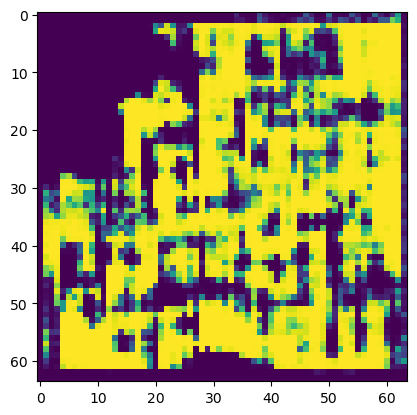

epoch = 481
Gen loss = tf.Tensor(0.5575016, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012892929, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 482
Gen loss = tf.Tensor(0.5368868, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0142905945, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 483
Gen loss = tf.Tensor(0.51030177, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017739447, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 484
Gen loss = tf.Tensor(0.52501255, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015273693, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 485
Gen loss = tf.Tensor(0.50964475, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016987193, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 486
Gen loss = tf.Tensor(0.5404046, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015811553, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 487
Gen loss = tf.Tensor(0.51818776, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01542563

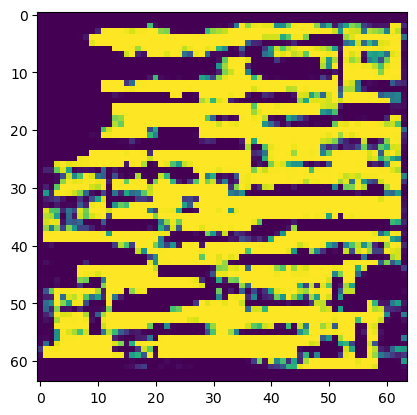

epoch = 491
Gen loss = tf.Tensor(0.6621855, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008762778, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 492
Gen loss = tf.Tensor(0.658782, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0071866172, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 493
Gen loss = tf.Tensor(0.6287922, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011060202, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 494
Gen loss = tf.Tensor(0.5951541, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013081297, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 495
Gen loss = tf.Tensor(0.58745944, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018558392, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 496
Gen loss = tf.Tensor(0.5526522, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011403658, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 497
Gen loss = tf.Tensor(0.5977563, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011916045, s

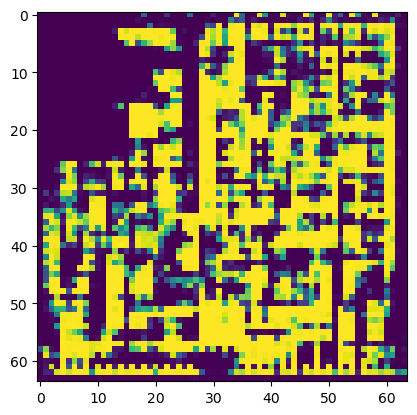

epoch = 501
Gen loss = tf.Tensor(0.6537221, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007906483, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 502
Gen loss = tf.Tensor(0.6353711, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009485214, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 503
Gen loss = tf.Tensor(0.62681615, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00926106, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 504
Gen loss = tf.Tensor(0.622966, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00922726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 505
Gen loss = tf.Tensor(0.630719, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008683581, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 506
Gen loss = tf.Tensor(0.670608, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0075710304, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 507
Gen loss = tf.Tensor(0.723579, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01737824, shape=(

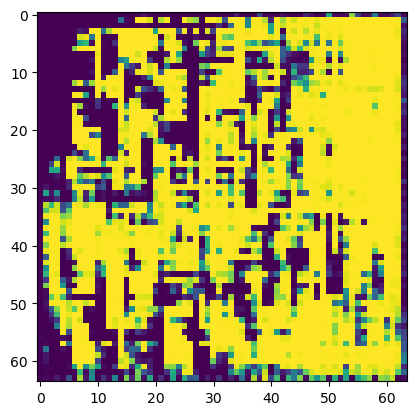

epoch = 511
Gen loss = tf.Tensor(0.67597824, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009507663, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 512
Gen loss = tf.Tensor(0.6749368, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009469585, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 513
Gen loss = tf.Tensor(0.7297747, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0058152545, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 514
Gen loss = tf.Tensor(0.7112526, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004653573, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 515
Gen loss = tf.Tensor(0.7351571, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007011102, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 516
Gen loss = tf.Tensor(0.67856914, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0055171587, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 517
Gen loss = tf.Tensor(0.7068856, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004722033

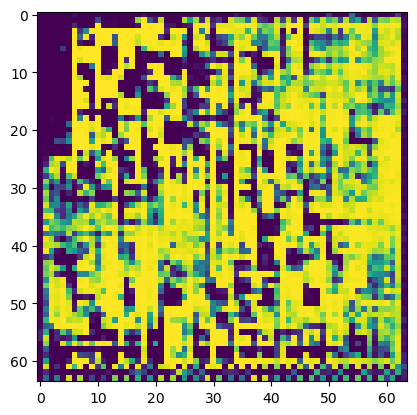

epoch = 521
Gen loss = tf.Tensor(0.65227765, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0091086235, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 522
Gen loss = tf.Tensor(0.65310663, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012266946, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 523
Gen loss = tf.Tensor(0.7632365, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024119677, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 524
Gen loss = tf.Tensor(0.76120806, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018289119, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 525
Gen loss = tf.Tensor(0.7266862, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02691059, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 526
Gen loss = tf.Tensor(0.62560743, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03305352, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 527
Gen loss = tf.Tensor(0.71730846, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024968877

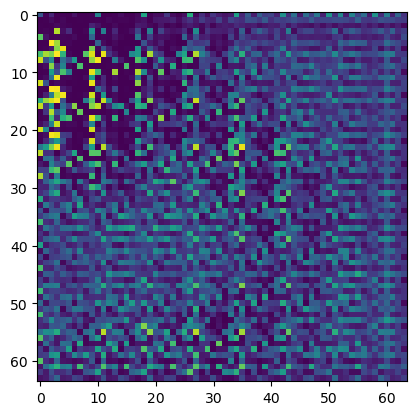

epoch = 531
Gen loss = tf.Tensor(0.38252416, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0659905, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 532
Gen loss = tf.Tensor(0.38690552, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08578322, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 533
Gen loss = tf.Tensor(0.548605, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.032913707, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 534
Gen loss = tf.Tensor(0.5207896, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054938186, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 535
Gen loss = tf.Tensor(0.5067006, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036266476, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 536
Gen loss = tf.Tensor(0.5073271, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041899856, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 537
Gen loss = tf.Tensor(0.42800272, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03815069, shap

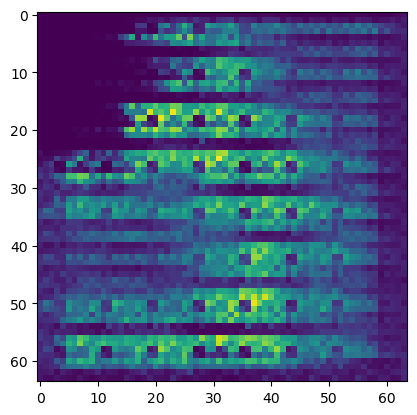

epoch = 541
Gen loss = tf.Tensor(0.49561396, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019346861, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 542
Gen loss = tf.Tensor(0.52603394, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011948485, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 543
Gen loss = tf.Tensor(0.41533658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.034753483, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 544
Gen loss = tf.Tensor(0.5281834, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01788255, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 545
Gen loss = tf.Tensor(0.578559, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019522214, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 546
Gen loss = tf.Tensor(0.5548772, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014800719, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 547
Gen loss = tf.Tensor(0.4813539, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07532528, sh

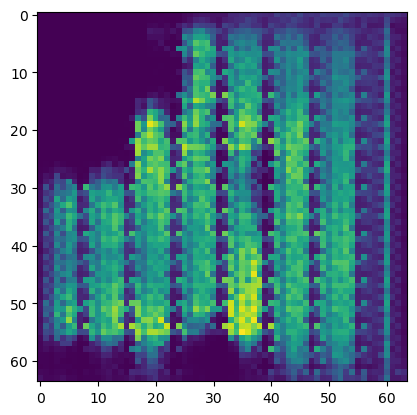

epoch = 551
Gen loss = tf.Tensor(0.48307136, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018115291, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 552
Gen loss = tf.Tensor(0.5090721, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023047915, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 553
Gen loss = tf.Tensor(0.5281578, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01200135, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 554
Gen loss = tf.Tensor(0.50236887, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015862126, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 555
Gen loss = tf.Tensor(0.43930689, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023872107, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 556
Gen loss = tf.Tensor(0.48682192, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022639958, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 557
Gen loss = tf.Tensor(0.50125927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023194313

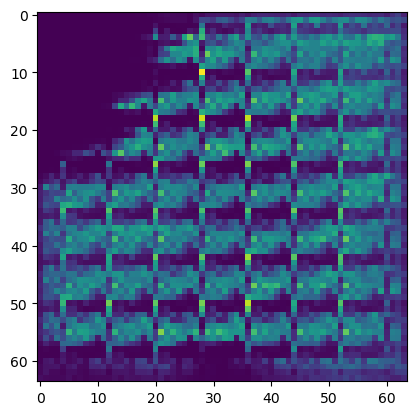

epoch = 561
Gen loss = tf.Tensor(0.48958817, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016197404, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 562
Gen loss = tf.Tensor(0.5205335, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01201458, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 563
Gen loss = tf.Tensor(0.62608904, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008200411, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 564
Gen loss = tf.Tensor(0.5838568, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017591933, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 565
Gen loss = tf.Tensor(0.516898, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022493219, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 566
Gen loss = tf.Tensor(0.54180795, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02044508, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 567
Gen loss = tf.Tensor(0.5307115, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016857155, sh

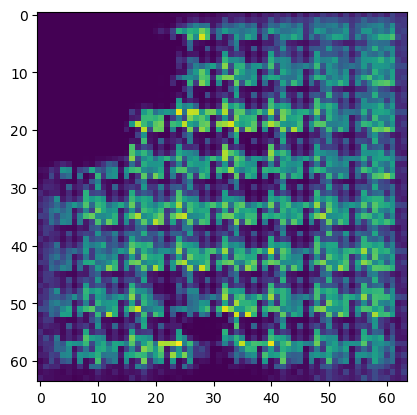

epoch = 571
Gen loss = tf.Tensor(0.60476094, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008241526, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 572
Gen loss = tf.Tensor(0.6271419, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008260795, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 573
Gen loss = tf.Tensor(0.56961614, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010639429, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 574
Gen loss = tf.Tensor(0.48796284, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018057978, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 575
Gen loss = tf.Tensor(0.56484634, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01745058, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 576
Gen loss = tf.Tensor(0.57629186, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013022303, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 577
Gen loss = tf.Tensor(0.5941526, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010305348

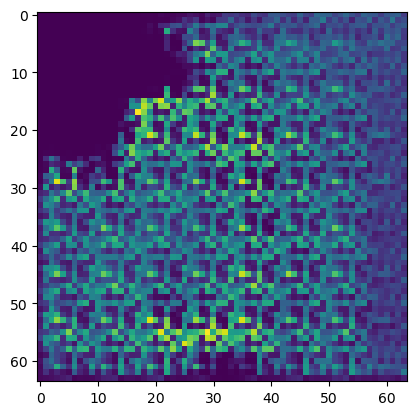

epoch = 581
Gen loss = tf.Tensor(0.57787204, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014139626, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 582
Gen loss = tf.Tensor(0.56053644, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010169209, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 583
Gen loss = tf.Tensor(0.56291884, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013822406, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 584
Gen loss = tf.Tensor(0.5625561, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011122865, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 585
Gen loss = tf.Tensor(0.5996502, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012396694, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 586
Gen loss = tf.Tensor(0.59412086, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016952485, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 587
Gen loss = tf.Tensor(0.6609008, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01793384,

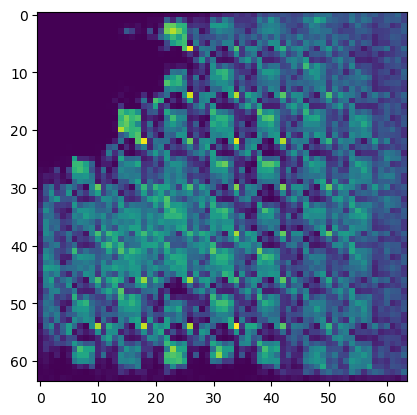

epoch = 591
Gen loss = tf.Tensor(0.5606497, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011981596, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 592
Gen loss = tf.Tensor(0.5133312, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029733444, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 593
Gen loss = tf.Tensor(0.6135372, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011233073, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 594
Gen loss = tf.Tensor(0.5449498, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020700479, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 595
Gen loss = tf.Tensor(0.51159734, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022174759, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 596
Gen loss = tf.Tensor(0.48664355, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.031211337, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 597
Gen loss = tf.Tensor(0.53324366, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014658481,

In [367]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

(64, 64)


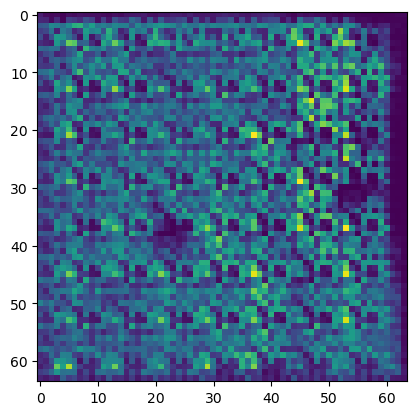

In [368]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

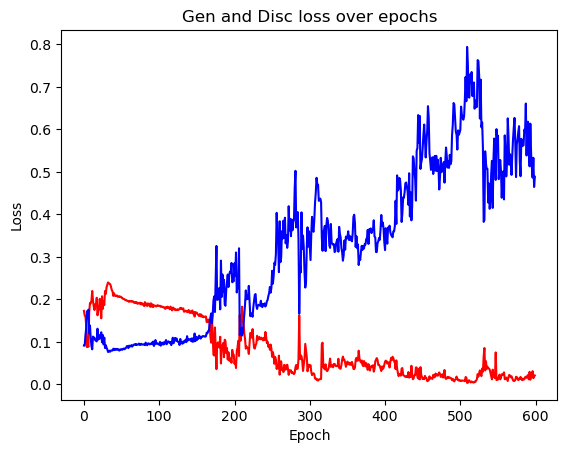

In [369]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8400,) + inhomogeneous part.

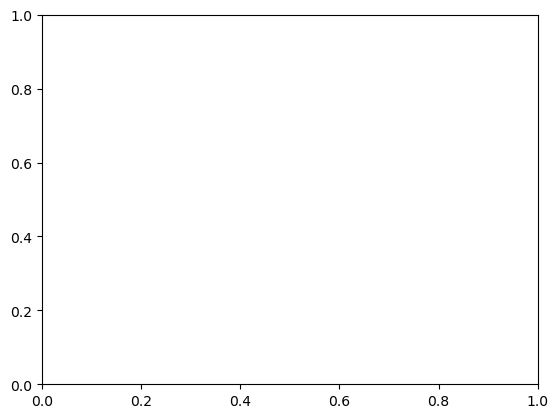

In [370]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')